In [18]:
%%capture
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [19]:
%%capture
import sys
sys.path.append('/home/wrwt/Programming/pygraphmodels')
import graphmodels as gm

In [20]:
import warnings
warnings.filterwarnings('ignore', module='matplotlib')
warnings.filterwarnings('ignore', module='IPython')

In [21]:
def bic_score(x, pa):
    l = gm.information.discrete_mutual_information(data[[x]], data[pa]) - gm.information.discrete_entropy(data[[x]])
    n = data.shape[0]
    k = np.prod(true_dgm.factor(x).table.shape) - 1
    result = -n*l + 0.5 * np.log(n) * k
    return result

In [89]:
from os import listdir
import os.path
NETWORKS_PATH = '/home/wrwt/Programming/pygraphmodels/networks/'
network_filenames = listdir(NETWORKS_PATH)
true_dgm = gm.DGM.read(os.path.join(NETWORKS_PATH, 'alarm.bif'))
true_dgm.draw()

In [90]:
data = true_dgm.rvs(100000)

In [24]:
from graphmodels.information import discrete_entropy, discrete_mutual_information

In [25]:
%%timeit
#discrete_mutual_information(data[['Alarm']], data[['MaryCalls', 'JohnCalls']])

100000000 loops, best of 3: 8.27 ns per loop


In [26]:
from itertools import product
class MatrixGraph:
    def __init__(self, adjacency_matrix, names_to_idx=None):
        self.adj = adjacency_matrix
        self.names_to_idx = names_to_idx
        if names_to_idx is None:
            self.names_to_idx = {i:i for i in range(adj.shape[0])}
            
    @property
    def n(self):
        return self.adj.shape[0]
    
    @property
    def m(self):
        return np.sum(self.adj)
    
    @property
    def names(self):
        idx_to_names = self.idx_to_names
        return [idx_to_names[i] for i in range(self.n)]
    
    def nodes(self):
        return list(range(self.n))
    
    @property
    def idx_to_names(self):
        return {i:node for node, i in self.names_to_idx.items()}
    
    @staticmethod
    def from_networkx_DiGraph(graph):
        names_to_idx = {node:i for i, node in enumerate(graph.nodes())}
        adj = np.zeros((len(names_to_idx), len(names_to_idx)))
        for u, v in graph.edges():
            adj[names_to_idx[u], names_to_idx[v]] = 1
        return MatrixGraph(adj, names_to_idx=names_to_idx)

    def to_networkx_DiGraph(self):
        result = nx.DiGraph()
        result.add_nodes_from(self.names_to_idx.keys())
        for i, j in product(range(self.n), repeat=2):
            if self.adj[i, j]:
                result.add_edge(self.idx_to_names[i], self.idx_to_names[j])
        return result
    
    def is_acyclic(self):
        return nx.is_directed_acyclic_graph(self.to_networkx_DiGraph())
    
    def draw(self):
        return gm.DGM(self.to_networkx_DiGraph()).draw()

In [27]:
%%capture
import theano
import theano.tensor as T
from theano.tensor import nnet
class Neurofunction:
    def __init__(self, n_in, n_hid, lambda_=1e-4):
        self.n_in = n_in
        self.n_hid = n_hid
        self.n_params = (self.n_in + 2) * self.n_hid + 1
        self.reset()
        
        self.W0 = T.dmatrix('W0')
        self.b0 = T.dvector('b0')
        self.W1 = T.dvector('W1')
        self.b1 = T.dscalar('b1')

        self.X = T.dmatrix('X')
        self.x = T.dvector('x')
        self.y = T.dvector('y')
        
        self.hidden = nnet.sigmoid(self.X.dot(self.W0) + self.b0)
        self.xhidden = nnet.sigmoid(self.x.dot(self.W0) + self.b0)
        self.out = self.hidden.dot(self.W1) + self.b1
        self.xout = self.xhidden.dot(self.W1) + self.b1
        
        self.loss = T.mean((self.out - self.y) ** 2) + lambda_ * (T.sum(self.W0 ** 2) + T.sum(self.W1 ** 2))
        
        self.theta_grad = T.concatenate([T.grad(self.loss, wrt=self.W0).flatten(),
                              T.grad(self.loss, wrt=self.W1).flatten(),
                              T.grad(self.loss, wrt=self.b0).flatten(),
                              [T.grad(self.loss, wrt=self.b1)]])
        self.loss_theta_grad_f = theano.function(inputs=[self.X, self.y, self.W0, self.W1, self.b0, self.b1],
                                           outputs=[self.loss, self.theta_grad])
        self.predict_f = theano.function(inputs=[self.X, self.W0, self.W1, self.b0, self.b1], 
                                         outputs=self.out, name='predict')
        
        self.x_grad = T.grad(-self.xout, wrt=self.x)
        self.loss_x_grad_f = theano.function(inputs=[self.x, self.W0, self.W1, self.b0, self.b1], 
                                            outputs=[-self.xout, self.x_grad])
    
        
    def _parse_params(self, theta):
        n_in = self.n_in
        n_hid = self.n_hid
        n_out = 1
        W0 = theta[:n_in*n_hid].reshape((n_in, n_hid))
        W1 = theta[n_in*n_hid:n_in*n_hid + n_hid*n_out]
        b0 = theta[n_in*n_hid + n_hid*n_out:n_in*n_hid + n_hid*n_out + n_hid]
        b1 = theta[n_in*n_hid + n_hid*n_out + n_hid]
        return W0, W1, b0, b1
        
    def reset(self):
        self.theta = np.random.rand(self.n_params)
        
    def fit(self, X, y, init=True):
        def loss_grad(theta):
            W0, W1, b0, b1 = self._parse_params(theta)
            return self.loss_theta_grad_f(X, y, W0, W1, b0, b1)
    
        res = sp.optimize.minimize(loss_grad, self.theta, method='L-BFGS-B', jac=True)
        self.theta = res['x']
        
    def __call__(self, X):
        params = self._parse_params(self.theta)
        return self.predict_f(np.atleast_2d(X), *params)
    
    def maximize(self, assignment=None):
        if assignment is None:
            assignment = [None] * self.n_in
        
        n_assigned = sum([1 if a is not None else 0 for a in assignment])
        x = np.random.rand(self.n_in - n_assigned)
        idx = [i for i, a in enumerate(assignment) if a is None]
        
        
        dispatch = {}
        for i, a in enumerate(assignment):
            if a is None:
                dispatch[len(dispatch)] = i
        
        def loss_grad(x_compl):
            x = np.array(assignment)
            for i, xi in enumerate(x_compl):
                x[dispatch[i]] = xi
            W0, W1, b0, b1 = self._parse_params(self.theta)
            loss, grad = self.loss_x_grad_f(x.astype('float'), W0, W1, b0, b1)
            grad = grad[idx]
            return loss, grad
        
        res = sp.optimize.minimize(loss_grad, x, method='L-BFGS-B', jac=True, 
                                   bounds=[(0, 1)] * (self.n_in - n_assigned))
        return res['x']

In [28]:
class ScoreBIC:
    def __init__(self, graph, data):
        self.graph = graph
        self.data = data
        self.n_values = {name: len(self.data[name].value_counts()) for name in self.data.columns}
        self.cache = {}
        
    def _footprint(self, node, parents):
        return tuple([node] + list(parents))
        
    def __call__(self, node, parents):
        fp = self._footprint(node, parents)
        if fp in self.cache:
            return self.cache[fp]
        
        pa_names = [self.graph.idx_to_names[idx] for idx, exists in enumerate(parents) if exists]
        node_name = self.graph.idx_to_names[node]
            
        k = self.n_values[node_name]*np.prod([self.n_values[pa_i] for pa_i in pa_names]) - 1
        n = self.data.shape[0]
        l = n*discrete_mutual_information(data[[node_name]], data[pa_names])
        
        result = l - 0.5 * np.log(n) * k
        self.cache[fp] = result
        return result

In [401]:
class NeuroScoreBIC:
    def __init__(self, graph, data, n_hid=10, lambda_=0.0001):
        self.graph = graph
        self.data = data
        self.n_values = {name: len(self.data[name].value_counts()) for name in self.data.columns}
        self.cache = {}
        self.model = {node: Neurofunction(self.graph.n - 1, n_hid, lambda_=lambda_) for node in self.graph.nodes()}
        self.traces = {node: [] for node in self.graph.nodes()}
    
    def _make_pa_short(self, node, parents):
        pa_short = list(parents)
        pa_short.pop(node)
        return tuple(pa_short)
    
    def _read_cache(self, node, parents):
        pa_short = self._make_pa_short(node, parents)
        return self.cache[node][pa_short]
        
    def _write_cache(self, node, parents, value, fit=False):
        pa_short = self._make_pa_short(node, parents)
        if node not in self.cache:
            self.cache[node] = {}
        self.cache[node][pa_short] = value
        if fit:
            X, y = zip(*self.cache[node].items())
            self.model[node].fit(X, y)
    
    def _in_cache(self, node, parents):
        pa_short = self._make_pa_short(node, parents)
        if node not in self.cache:
            return False
        if pa_short not in self.cache[node]:
            return False
        return True
    
    def _model_predict(self, node, parents):
        pa_short = self._make_pa_short(node, parents)
        return self.model[node](np.array(pa_short))
        
    def __call__(self, node, parents, trace=True, precise=True):
        if self._in_cache(node, parents):
            return self._read_cache(node, parents)
        
        if not precise:
            return self._model_predict(node, parents)
        
        pa_names = [self.graph.idx_to_names[idx] for idx, exists in enumerate(parents) if exists]
        node_name = self.graph.idx_to_names[node]
            
        k = self.n_values[node_name]*np.prod([self.n_values[pa_i] for pa_i in pa_names]) - 1
        n = self.data.shape[0]
        l = n*discrete_mutual_information(data[[node_name]], data[pa_names])
        
        result = l - 0.5 * np.log(n) * k
        
        if trace:
            self.traces[node].append((self._model_predict(node, parents), result))
        
        self._write_cache(node, parents, result, fit=trace)
        return result

In [335]:
mxg = MatrixGraph.from_networkx_DiGraph(true_dgm)
score = ScoreBIC(mxg, data)

In [336]:
mxg.names

['PAP',
 'VENTLUNG',
 'SAO2',
 'EXPCO2',
 'HR',
 'HREKG',
 'CVP',
 'KINKEDTUBE',
 'BP',
 'ERRCAUTER',
 'PULMEMBOLUS',
 'SHUNT',
 'MINVOLSET',
 'CATECHOL',
 'ERRLOWOUTPUT',
 'FIO2',
 'LVEDVOLUME',
 'INTUBATION',
 'STROKEVOLUME',
 'PRESS',
 'HRBP',
 'VENTMACH',
 'CO',
 'MINVOL',
 'HYPOVOLEMIA',
 'LVFAILURE',
 'VENTALV',
 'INSUFFANESTH',
 'TPR',
 'HISTORY',
 'HRSAT',
 'DISCONNECT',
 'VENTTUBE',
 'ARTCO2',
 'ANAPHYLAXIS',
 'PVSAT',
 'PCWP']

In [337]:
score(1, [0, 0, 0, 0, 0])

-17.269388197455342

In [338]:
score(1, [0, 0, 1, 0, 0])

26627.246086176961

In [339]:
score(1, [1, 0, 1, 0, 0])

26505.625666575561

In [340]:
score(4, [0, 0, 0, 0, 0])

-11.512925464970229

In [341]:
%load_ext line_profiler
%lprun -f ScoreBIC.__call__ score(4, [1, 1, 1, 1, 0])

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [342]:
class InvalidOperation(Exception): pass

class LocalOperation:
    def __init__(self, graph, fscore):
        self.graph = graph
        self.fscore = fscore
    
    def do(self):
        raise NotImplementedError()
    
    def undo(self):
        raise NotImplementedError()
        
    def score(self, **kwargs):
        raise NotImplementedError()

In [343]:
class AddEdge(LocalOperation):
    def __init__(self, graph, fscore, src, dst):
        LocalOperation.__init__(self, graph, fscore)
        self.src = src
        self.dst = dst
    
    def do(self):
        if self.graph.adj[self.src, self.dst]:
            raise InvalidOperation()
        self.graph.adj[self.src, self.dst] = 1
        if not self.graph.is_acyclic():
            self.graph.adj[self.src, self.dst] = 0
            raise InvalidOperation()
        return self
    
    def undo(self):
        self.graph.adj[self.src, self.dst] = 0
        return self
    
    def score(self, **kwargs):
        pa = self.graph.adj[:, self.dst].copy()
        score = -self.fscore(self.dst, pa, **kwargs)
        pa[self.src] = 1
        score += self.fscore(self.dst, pa, **kwargs)
        return score

In [344]:
class RemoveEdge(LocalOperation):
    def __init__(self, graph, fscore, src, dst):
        LocalOperation.__init__(self, graph, fscore)
        self.src = src
        self.dst = dst
    
    def do(self):
        if not self.graph.adj[self.src, self.dst]:
            raise InvalidOperation()
        self.graph.adj[self.src, self.dst] = 0
        return self
    
    def undo(self):
        self.graph.adj[self.src, self.dst] = 1
        return self
    
    def score(self, **kwargs):
        pa = self.graph.adj[:, self.dst].copy()
        score = -self.fscore(self.dst, pa, **kwargs)
        pa[self.src] = 0
        score += self.fscore(self.dst, pa, **kwargs)
        return score

In [345]:
class ReverseEdge(LocalOperation):
    def __init__(self, graph, fscore, src, dst):
        LocalOperation.__init__(self, graph, fscore)
        self.src = src
        self.dst = dst
        
    def do(self):
        if not self.graph.adj[self.src, self.dst]:
            raise InvalidOperation()
        self.graph.adj[self.src, self.dst] = 0
        self.graph.adj[self.dst, self.src] = 1
        if not self.graph.is_acyclic():
            self.graph.adj[self.src, self.dst] = 1
            self.graph.adj[self.dst, self.src] = 0
            raise InvalidOperation()
        return self
    
    def undo(self):
        self.graph.adj[self.src, self.dst] = 1
        self.graph.adj[self.dst, self.src] = 0
        return self
    
    def score(self, **kwargs):
        pa = self.graph.adj[:, self.dst].copy()
        score = -self.fscore(self.dst, pa, **kwargs)
        pa[self.src] = 0
        score += self.fscore(self.dst, pa, **kwargs)
        
        pa = self.graph.adj[:, self.src].copy()
        score -= self.fscore(self.src, pa, **kwargs)
        pa[self.dst] = 1
        score += self.fscore(self.src, pa, **kwargs)
        return score

In [362]:
mxg = MatrixGraph.from_networkx_DiGraph(true_dgm)
score = ScoreBIC(mxg, data)

In [363]:
mxg.draw()

In [364]:
mxg.names

['PAP',
 'VENTLUNG',
 'SAO2',
 'EXPCO2',
 'HR',
 'HREKG',
 'CVP',
 'KINKEDTUBE',
 'BP',
 'ERRCAUTER',
 'PULMEMBOLUS',
 'SHUNT',
 'MINVOLSET',
 'CATECHOL',
 'ERRLOWOUTPUT',
 'FIO2',
 'LVEDVOLUME',
 'INTUBATION',
 'STROKEVOLUME',
 'PRESS',
 'HRBP',
 'VENTMACH',
 'CO',
 'MINVOL',
 'HYPOVOLEMIA',
 'LVFAILURE',
 'VENTALV',
 'INSUFFANESTH',
 'TPR',
 'HISTORY',
 'HRSAT',
 'DISCONNECT',
 'VENTTUBE',
 'ARTCO2',
 'ANAPHYLAXIS',
 'PVSAT',
 'PCWP']

In [365]:
op = AddEdge(mxg, score, 0, 3)
op.score

<bound method AddEdge.score of <__main__.AddEdge instance at 0x7f70aab4b098>>

In [366]:
mxg.adj[0, 1] = 1
mxg.draw()

In [370]:
op = RemoveEdge(mxg, score, 0, 1)
op.score()

0.0

In [371]:
op.do()

InvalidOperation: 

In [372]:
op.score()

0.0

In [373]:
from itertools import product, permutations
class GreedySearch:
    def __init__(self, graph, fscore):
        self.graph = graph
        self.fscore = fscore
        self.ops = []
        self.ops += [AddEdge(graph, fscore, u, v) for u, v in permutations(graph.nodes(), 2)]
        self.ops += [RemoveEdge(graph, fscore, u, v) for u, v in permutations(graph.nodes(), 2)]
        self.ops += [ReverseEdge(graph, fscore, u, v) for u, v in permutations(graph.nodes(), 2)]
        
    def iteration(self):
        [op.score() for op in self.ops]
        self.ops.sort(reverse=True, key=lambda op: op.score())
        for op in self.ops:
            if op.score() < 0:
                return True
            try:
                op.do()
                return False
            except InvalidOperation:
                pass
        return True
    
    def __call__(self):
        while not self.iteration():
            pass

In [374]:
class NeuroGreedySearch(GreedySearch):
    def iteration(self):
        self.ops.sort(reverse=True, key=lambda op: op.score(precise=False))
        for op in self.ops:
            if op.score() < 0:
                return True
            try:
                op.do()
                return False
            except InvalidOperation:
                pass
        return True

In [375]:
true_dgm.draw()

In [376]:
mx = MatrixGraph.from_networkx_DiGraph(true_dgm)
mx.adj = np.zeros(mx.adj.shape)
mx.draw()

In [377]:
def generate_subset(nargs, kmin=1, kmax=4, size=1):
    """
    Generate `size` random subsets of parents for node `target` with factor `factor` 
    and calculate discrete mutual information for them.
    Number of parents lies between kmin and kmax
    """
    
    n = np.random.randint(low=kmin, high=kmax+1, size=size)
    result = []
    score = []
    for i, cn in enumerate(n):
        current = np.random.choice(range(nargs), size=cn, replace=False)
        result.append([1.0 if arg in current else 0.0 for arg in range(nargs)])
    return np.vstack(result)

In [402]:
score = NeuroScoreBIC(mx, data, n_hid=mx.n)

In [ ]:
from __future__ import print_function
import sys
def burnin(mx, score):
    for node in mx.nodes():
        print(node, end=' ')
        sys.stdout.flush()
        X = generate_subset(mx.n - 1, size=1000)
        y = []
        for x in X:
            x = np.hstack([x[:node], [0], x[node:]])
            y.append(score(node, x, trace=False))
        score.model[node].fit(X, y)
        
%lprun -f NeuroScoreBIC.__call__ burnin(mx, score)

0 

In [389]:
gs = GreedySearch(mx, score)

In [390]:
score.model[0].n_in

36

In [391]:
for i in range(10):
    gs.iteration()

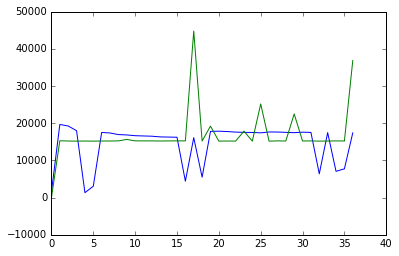

In [399]:
plt.plot(score.traces[6])

In [384]:
np.argmax([len(trace) for trace in score.traces.values()])

28

In [385]:
%lprun -f AddEdge.score gs.iteration()

In [388]:
mx.draw()

In [ ]:
var = 'Alarm'
mx.to_networkx_DiGraph().predecessors(var), true_dgm.predecessors(var)